In [1]:
pip install ydata-profiling

In [2]:
import ydata_profiling
import pandas as pd

# Cargar archivos
ratings = pd.read_csv("u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])
movies = pd.read_csv("u.item", sep="|", encoding="latin-1", header=None, usecols=[0, 1], names=["item_id", "title"])


In [3]:
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
movies.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [5]:
ratings.describe()


,user_id,item_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [7]:
from pandas_profiling import ProfileReport


/tmp/ipython-input-7-3063248848.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [8]:

profile = ProfileReport(ratings, title="Reporte EDA de Ratings", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 4/4 [00:00<00:00, 14.22it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
ratings['date'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year_month'] = ratings['date'].dt.to_period('M')



In [10]:
import matplotlib.pyplot as plt


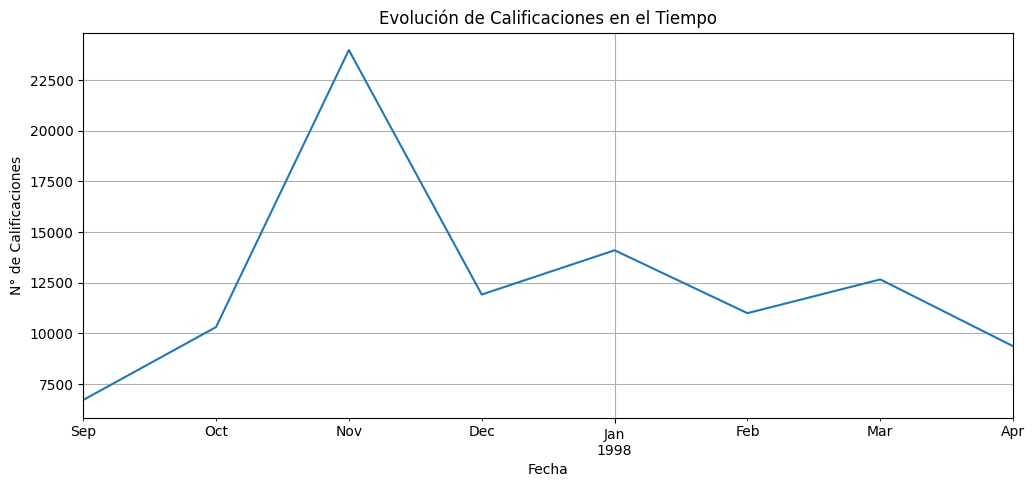

In [11]:
ratings.groupby("year_month").size().plot(kind="line", figsize=(12, 5), title="Evolución de Calificaciones en el Tiempo")
plt.ylabel("N° de Calificaciones")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()

In [12]:
import numpy as np

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

In [14]:
ratings['date'] = pd.to_datetime(ratings['timestamp'], unit='s')

In [15]:
ratings.describe()

,user_id,item_id,rating,timestamp,date
count,100000.00000,100000.000000,100000.000000,1.000000e+05,100000
mean,462.48475,425.530130,3.529860,8.835289e+08,1997-12-31 00:40:51.488619904
min,1.00000,1.000000,1.000000,8.747247e+08,1997-09-20 03:05:10
25%,254.00000,175.000000,3.000000,8.794487e+08,1997-11-13 19:18:29.500000
50%,447.00000,322.000000,4.000000,8.828269e+08,1997-12-22 21:42:24
75%,682.00000,631.000000,4.000000,8.882600e+08,1998-02-23 18:53:04
max,943.00000,1682.000000,5.000000,8.932866e+08,1998-04-22 23:10:38
std,266.61442,330.798356,1.125674,5.343856e+06,NaN


In [16]:
data = ratings.merge(movies, on="item_id", how="left")

In [ ]:
user_item_mat = data.pivot_table(index='user_id', columns='title', values='rating',aggfunc='mean').fillna(0)

In [21]:
user_similarity = cosine_similarity(user_item_mat)
user_sim_df = pd.DataFrame(user_similarity, index=user_item_mat.index, columns=user_item_mat.index)

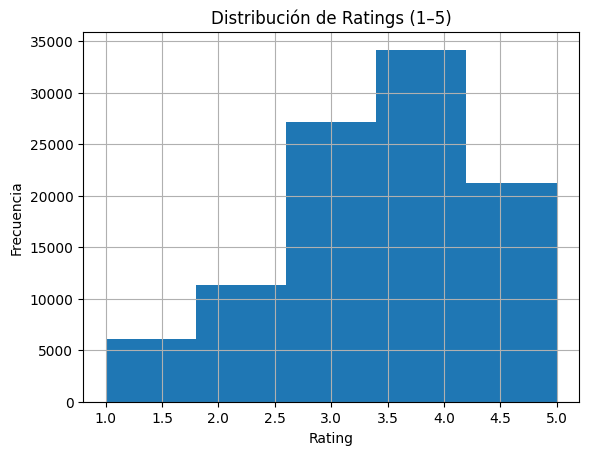

In [22]:
ratings['rating'].hist(bins=5)
plt.title("Distribución de Ratings (1–5)")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.show()

In [23]:
user_item_mat_centered = user_item_mat.sub(user_item_mat.mean(axis=1), axis=0)

In [24]:
svd = TruncatedSVD(n_components=20, random_state=42)
latent_matrix = svd.fit_transform(user_item_mat_centered)

In [25]:
def recomendar_peliculas(user_id, user_item_mat, n=5):
    user_ratings = user_item_mat.loc[user_id]
    peliculas_no_vistas = user_ratings[user_ratings == 0]

    # Similitud entre películas
    item_similarity = cosine_similarity(user_item_mat.T)
    item_sim_df = pd.DataFrame(item_similarity, index=user_item_mat.columns, columns=user_item_mat.columns)

    scores = {}

    for pelicula in peliculas_no_vistas.index:
        sim_scores = item_sim_df[pelicula]
        rated_movies = user_ratings[user_ratings > 0].index
        score = sum(sim_scores[rated_movies] * user_ratings[rated_movies])
        scores[pelicula] = score

    top_recommendations = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:n]
    return pd.DataFrame(top_recommendations, columns=["Película", "Score"])


In [26]:
recomendar_peliculas(10, user_item_mat)

,Película,Score
0,Back to the Future (1985),327.715430
1,E.T. the Extra-Terrestrial (1982),318.155628
2,"Empire Strikes Back, The (1980)",317.498715
3,Blade Runner (1982),312.632345
4,"Fugitive, The (1993)",311.699217


CAP 5

In [27]:
# Seleccionamos variables predictoras y objetivo
X = data[['user_id', 'item_id']]
y = data['rating']

# Verificamos dimensiones
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (100000, 2)
y shape: (100000,)


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)


Tamaño del conjunto de entrenamiento: (80000, 2)
Tamaño del conjunto de prueba: (20000, 2)


In [29]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='multinomial', max_iter=1000)
logreg.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [30]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [31]:
from sklearn.svm import SVC

svm = SVC(decision_function_shape='ovo')
svm.fit(X_train, y_train)


SVC(decision_function_shape='ovo')

In [37]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

CAP 6

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                Modelo  Accuracy  Recall Clase 1  Precision Clase 1  \
2        Random Forest     0.670        0.606061           0.625000   
3                  SVM     0.575        0.606061           0.555556   
0  Logistic Regression     0.525        0.575758           0.612903   
1        Decision Tree     0.395        0.393939           0.684211   

   F1 Clase 1  
2    0.615385  
3    0.579710  
0    0.593750  
1    0.500000  


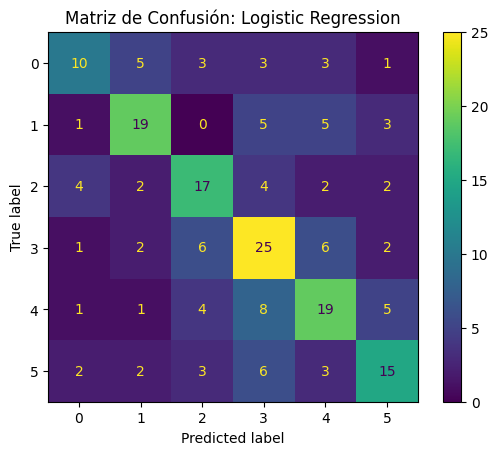

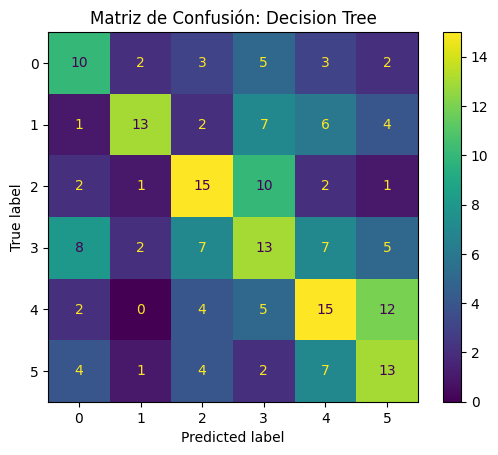

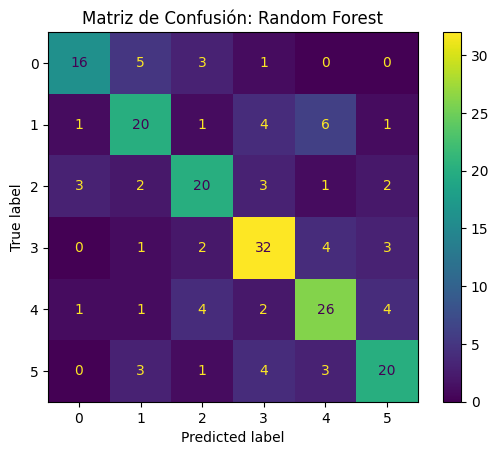

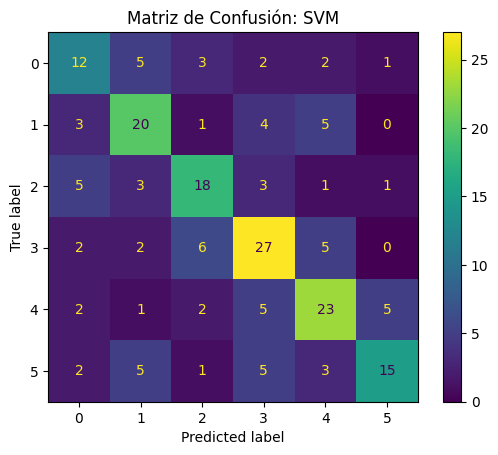

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

# Simulación de datos multiclase (6 clases)
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000,
                           n_features=20,
                           n_informative=15,
                           n_classes=6,
                           random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definimos los modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='linear', decision_function_shape='ovo', probability=True, random_state=42)
}

# Entrenamiento, predicción y evaluación
results = []
conf_matrices = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices[name] = cm

    results.append({
        "Modelo": name,
        "Accuracy": acc,
        "Recall Clase 1": report["1"]["recall"] if "1" in report else 0.0,
        "Precision Clase 1": report["1"]["precision"] if "1" in report else 0.0,
        "F1 Clase 1": report["1"]["f1-score"] if "1" in report else 0.0
    })

# Resultados finales
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print(results_df)

# Mostrar matrices de confusión
for name, cm in conf_matrices.items():
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Matriz de Confusión: {name}")
    plt.show()
